In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import svgpathtools
from svgpathtools import Line, Path, svg2paths, wsvg, disvg
import numpy as np
import matplotlib.pyplot as plt
import math
import cvxpy as cp
import scipy
import scipy.ndimage
from track import Track
import csv
import tire
import serde
import trajectory_planning_helpers

plt.style.use('seaborn')

# Parameters

In [3]:
SVG_OFFSET = (-10.0, 10.0)

# SEGMENT_LENGTH = 0.05  # in meters
SEGMENT_LENGTH = 0.05
BOUNDARY_SEGMENT_LENGTH = 0.01 # in meters, finer 
TRACK_WIDTH = 1.3
ROBOT_HALF_WIDTH = 0.2 # includes safety padding
G = 9.807

ROBOT_MASS = 1.457 # kg
ROBOT_LF = 0.128
ROBOT_LR = 0.137
ROBOT_I = 0.0965

MIU = 1.2
F_MIU = 1.05

TOP_SPEED = 9.5

MAX_ACCEL = MIU*G

# Export Track

Racing path length is  48.10618601736664


c:\projects\zoomies\venv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[0][962]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
c:\projects\zoomies\venv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:226: RuntimeWarning: Setting x[1][962]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %


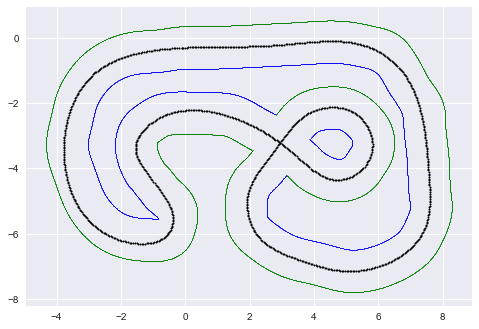

In [15]:
paths, attrs = svg2paths(r'C:\projects\zoomies\data\map\map.svg')
racing_path = paths[0]
left_boundary = paths[1]
right_boundary = paths[2]

print("Racing path length is ", racing_path.length() / 1000)

def make_pts(path, segment_length):
  L = path.length()
  steps = int(L / (segment_length * 1000))
  tpts = [path.ilength(L*k/steps) for k in range(steps)]
  pts = [path.point(t) / 1000 for t in tpts]
  # SVG y-axis is reversed
  return [[p.real + SVG_OFFSET[0] for p in pts], [-p.imag + SVG_OFFSET[1] for p in pts]]

track = Track()
track.racing_line_from_points(make_pts(racing_path, SEGMENT_LENGTH), smooth_factor=1)
track.set_left_boundary(make_pts(left_boundary, BOUNDARY_SEGMENT_LENGTH))
track.set_right_boundary(make_pts(right_boundary, BOUNDARY_SEGMENT_LENGTH))

track.display()

In [6]:
MAX_ACCEL=1.3*9.81

from collections import namedtuple
PathPoint = namedtuple('PathPoint', ['s', 'heading', 'curvature', 'velocity', 'x', 'y'])
rp = []

with open(r'd:\tmp\car\traj\traj_race_cl.csv') as f:
    reader = csv.DictReader(f, ['s_m', 'x_m', 'y_m', 'psi_rad', 'kappa_radpm', 'vx_mps', 'ax_mps2'],
                            delimiter=';')
    it = iter(reader)
    next(it)  # guid
    next(it)  # ggv hash
    next(it)  # headers
    for row in it:
        assert(row['s_m'] is not None)
        assert(row['x_m'] is not None)
        assert(row['y_m'] is not None)
        assert(row['psi_rad'] is not None)
        assert(row['vx_mps'] is not None)
        pp = PathPoint(float(row['s_m']), float(row['psi_rad']), float(row['kappa_radpm']), float(row['vx_mps']), 
                        float(row['x_m']), float(row['y_m']))
        rp.append(pp)

headings = np.array([x.heading for x in rp]) + math.pi / 2  # their convention is north is 0.
headings = trajectory_planning_helpers.normalize_psi.normalize_psi(headings)

s = [x.s for x in rp]
average_s = np.average(np.diff(s))

final_rp = []
for (pp, heading) in zip(rp, headings):
    final_rp.append(pp._replace(heading=heading))

print("Average s", average_s, " accel", MAX_ACCEL)
serde.write(r'c:\projects\zoomies\data\track\0928\path_1_3', average_s, MAX_ACCEL, final_rp)

Average s 0.04998694076923077  accel 9.81


In [9]:
with open(r'd:\tmp\car\circuit_launch.csv', 'w', newline='') as csvfile:
    w = csv.writer(csvfile, delimiter=',')
    # x_m,y_m,w_tr_right_m,w_tr_left_m
    w.writerow(['# x_m', 'y_m', 'w_tr_right_m', 'w_tr_left_m'])
    left_dists, right_dists = track.boundary_dist(0.0)
    for (x, y, lw, rw) in zip(track.pts[0], track.pts[1], left_dists, right_dists):
        w.writerow([x, y, rw, lw])

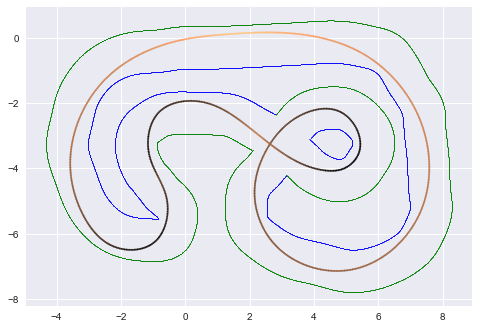

In [34]:
track.racing_line_from_points([[x.x for x in final_rp], [x.y for x in final_rp]], smooth_factor=0.1)
track.display([x.velocity for x in final_rp])

In [42]:
final_rp[0]

PathPoint(s=0.0, heading=0.22246902679489655, curvature=-0.1399036, velocity=6.9604661, x=-0.1073468, y=-0.075469)